In [1]:
# I used this notebook for a while, but as I worked on the Cell data storage code in
# "Zelda Adventure Game Data", the line between sprites and other data became blurry.
# So I stopped working here and focused on "Zelda Adventure Game Data".

import struct
import json
import datetime
import math
import importlib
import PIL.Image

import cdi_filesystem
importlib.reload(cdi_filesystem)

import struct_stream
importlib.reload(struct_stream)

import cdi_images
importlib.reload(cdi_images)
getClut = cdi_images.getClut
clut8ToRGB = cdi_images.clut8ToRGB
dyuvToRGB = cdi_images.dyuvToRGB
dyuvToRGBBackground = cdi_images.dyuvToRGBBackground

StructStream = struct_stream.StructStream

# Takes as input the files produced by the Mame CDH Format Decompressor notebook

gameData = cdi_filesystem.loadCdiImageFile("Zeldas Adventure (Europe).dat")

import za_filesystem
importlib.reload(za_filesystem)
ResourceMap = za_filesystem.ResourceMap

mainMapStream = StructStream(gameData.files["zelda.mapres"].getBytes(), endianPrefix=">")
mainFile = ResourceMap(mainMapStream, gameData.files["zelda.rtf"])

def parseSubFiles(mapSubfileName, realFileName):
    map = mainFile.subFiles[mapSubfileName].getBytes()
    stream = StructStream(map, endianPrefix=">")
    return ResourceMap(stream, gameData.files[realFileName])

zeldaRlFiles = parseSubFiles("rmap", "zelda_rl.rtf")
overFiles = parseSubFiles("omap", "over.rtf")
underFiles = parseSubFiles("umap", "under.rtf")
audioFiles = parseSubFiles("amap", "zelda_audio.rtf")
#voiceFiles = parseSubFiles("vmap", "zelda_voice.rtf")

parsing file:   0%|          | 0/1 [00:00<?, ?it/s]

building sectors:   0%|          | 0/220024 [00:00<?, ?it/s]

building files:   0%|          | 0/12 [00:00<?, ?it/s]

searching files for modules:   0%|          | 0/12 [00:00<?, ?it/s]

searching cdi_zelda for modules:   0%|          | 0/65 [00:00<?, ?it/s]

locating module name:   0%|          | 0/62 [00:00<?, ?it/s]

locating module name:   0%|          | 0/3 [00:00<?, ?it/s]

locating module name:   0%|          | 0/1 [00:00<?, ?it/s]

locating module name:   0%|          | 0/2 [00:00<?, ?it/s]

ResourceTreeSet(count=5, base=20, list=40)
Mismatched set node size; expected 1304 found 40
amap [] [] [3]
vmap [] [] [3]
rmap [] [] [3]
omap [] [] [5]
umap [] [] [4]
drt [3] [] []
nvr [40] [] []
zinit [1, 3, 1, 1] [18] [1, 16, 10]
pls [40, 16] [4] [1, 1, 1]
plsl [4] [] []
ent [40, 22] [19] [1, 2, 1]
entl [4] [] []
opt [40, 29] [] [1, 1]
invent [9, 17, 7, 40, 4, 1] [] [1, 1]
map0 [40, 1] [] [1, 1]
map1 [40, 1] [] [1, 1]
map2 [40, 1] [] [1, 1]
map3 [40, 1] [] [1, 1]
map4 [40, 1] [] [1, 1]
map5 [40, 1] [] [1, 1]
map6 [40, 1] [] [1, 1]
map7 [40, 1] [] [1, 1]
map8 [40, 1] [] [1, 1]
wp01 [] [3] [1, 3]
wp02 [] [3] [1, 1]
wp03 [] [3] [1, 1]
wp04 [] [3] [1, 4]
wp05 [] [3] [1, 2]
wp06 [] [3] [1, 1]
wp07 [] [3] [1, 3]
wp08 [] [3] [1, 3]
wp09 [] [3] [1, 2]
wp10 [] [3] [1, 1]
wp11 [] [3] [1, 2]
wp12 [] [3] [1, 1]
wp13 [] [3] [1, 2]
wp14 [] [3] [1, 1]
wp17 [] [3] [1, 1]
wp18 [] [3] [1, 2]
wp19 [] [3] [1, 2]
wp20 [] [3] [1, 2]
wp21 [] [3] [1, 1]
wp23 [] [3] [1, 2]
wp24 [] [3] [1, 1]
zd [] [] []
dtc 

Clut size: 256 colors


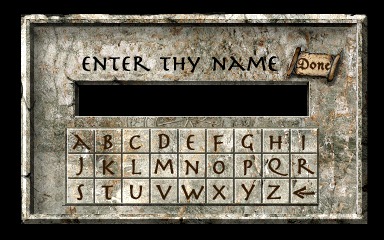

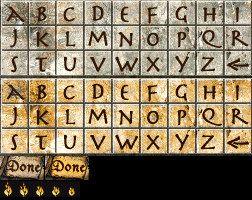

In [2]:
clut = getClut(mainFile.subFiles["ent"].getBytes(kind="data"))
#display(clut8ToRGB(parsedMapres.subFiles["ent"].getBytes(0, 40, kind="video"), 384, 240, clut))
#display(clut8ToRGB(parsedMapres.subFiles["ent"].getBytes(40, 62, kind="video"), 252, 200, clut))
#display(clut8ToRGB(parsedMapres.subFiles["entl"].getBytes(kind="video"), 524, 16, clut))
display(clut8ToRGB(mainFile.subFiles["ent"].getRecord(0, "video"), 384, 240, clut))
display(clut8ToRGB(mainFile.subFiles["ent"].getRecord(1, "video"), 252, 200, clut))
display(clut8ToRGB(mainFile.subFiles["entl"].getRecord(0, "video"), 524, 16, clut))

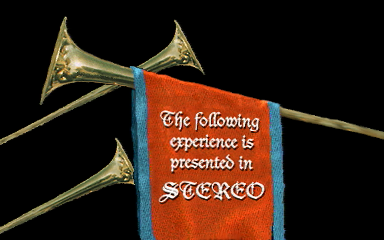

In [3]:
display(dyuvToRGBBackground(zeldaRlFiles.subFiles["str"].getRecord(0, "video")))

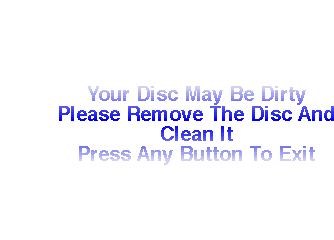

In [4]:
drt = mainFile.subFiles["drt"]

drtClut = []
for i in range(14, 0, -1):
    drtClut.append((i * 15, i * 15, 0xEF))
for i in range(15):
    drtClut.append((i * 15, i * 15, 0xEF))

while len(drtClut) < 0x80:
    drtClut.append((0, 0, 0))
drtClut.extend([
    (0, 0, 0),
    (0xEF, 0xEF, 0xEF),
    (0xC8, 0xC8, 0xC8),
    (0, 0, 0xC8),
    (0, 0, 0xEF)
])
flatDrtClut = b''
for c in drtClut:
    for b in c:
        flatDrtClut += b.to_bytes(1)
    

def rl7ToRGB(data, palette:bytes, transparentColor = None, emptySpaceColorIndex = 0, forceWidth = None):
    assert isinstance(palette, bytes)
    lastNonzeroIndex = 0
    for i, b in enumerate(data):
        if b != 0:
            lastNonzeroIndex = i
    #print(lastNonzeroIndex, len(data))
    truncImageData = data[:lastNonzeroIndex + 2]

    i = 0
    pixelRows = []
    currentRow = b''
    while i < len(truncImageData):
        if truncImageData[i] & 0x80 == 0:
            #print("single")
            currentRow += truncImageData[i].to_bytes(1)
            i += 1
        elif truncImageData[i + 1] == 0:
            pixelRows.append(currentRow)
            currentRow = b''
            i += 2
        else:
            c = (truncImageData[i] & 0x7F).to_bytes(1)
            for _ in range(truncImageData[i + 1]):
                currentRow += c
            i += 2
    if len(currentRow) != 0:
        print("last row had data")
        pixelRows.append(currentRow)
    del currentRow
    del i

    if forceWidth == None:
        width = max([len(r) for r in pixelRows])
    else:
        width = forceWidth
    height = len(pixelRows)
    pixels = b''
    for row in pixelRows:
        pixels += row 
        for _ in range(width - len(row)):
            pixels += emptySpaceColorIndex.to_bytes(1)
    assert len(pixels) == width * height

    if len(pixels) == 0:
        print("Empty frame")
        ret = PIL.Image.frombytes('P', (1, 1), b'\0')
        ret.putpalette(b'\0\0\0\0', rawmode = "RGBA")
        return ret

    img = PIL.Image.frombytes('P', (width, height), pixels)

    
    rgbaPalette = b''
    i = 0
    while i < len(palette):
        c = palette[i:i + 3]
        rgbaPalette += c
        if c == transparentColor:
            rgbaPalette += b'\0'
        else:
            rgbaPalette += 0xFF.to_bytes(1)
        i += 3
    img.putpalette(rgbaPalette, rawmode="RGBA")
    return img

display(rl7ToRGB(drt.getBytes(), flatDrtClut, emptySpaceColorIndex=0x80, transparentColor=b'\0\0\0'))

In [5]:
from tqdm.notebook import trange

intro1Clut = getClut(zeldaRlFiles.subFiles["zi1_i"].getRecord(0, kind="data"))
def saveMovie(subfile, clut, outputName=None, transparentColor=b'\xFF\0\xFF'):
    if not outputName:
        outputName = subfile.name + ".gif"
    frames = []
    for i in trange(len(subfile.videoSizes)):
        frameData = subfile.getRecord(i, kind="video")
        frame = rl7ToRGB(frameData, intro1Clut, transparentColor=b'\xFF\0\xFF', forceWidth=384)
        frames.append(frame)
    frames[0].save(outputName, save_all=True, append_images=frames[1:], duration=0.1)

saveMovie(zeldaRlFiles.subFiles["zi1"], intro1Clut)
saveMovie(zeldaRlFiles.subFiles["zi3"], intro1Clut)

Clut size: 128 colors


  0%|          | 0/304 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [6]:
vbClut = getClut(zeldaRlFiles.subFiles["vb1"].getRecord(0, kind="data"))
saveMovie(zeldaRlFiles.subFiles["vb2"], vbClut)
saveMovie(zeldaRlFiles.subFiles["vbt1"], vbClut)
saveMovie(zeldaRlFiles.subFiles["vbt2"], vbClut)

Clut size: 128 colors


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
zinit = mainFile.subFiles["zinit"]

def parseShallowCompressedSpriteArray(data, palette):
    stream = StructStream(data, endianPrefix=">")
    length, reserved = stream.take("II")
    assert reserved == 0, reserved
    
    offsets = [stream.take("I") for _ in range(length)]
    sprites = [stream.takeFork(offsets[i + 1] - offsets[i]) for i in range(len(offsets) - 1)]
    sprites.append(stream)

    return [decompressSprite(sprite, palette) for sprite in sprites]


def decompressSprite(stream: StructStream, palette):
    lineCount = stream.take("I")
    stream = stream.takeFork(lineCount)

    #print(stream)

    pixels = b''
    while stream.peekRaw(4) != b'\0\0\0\0':
        skip, size = stream.take("HH")
        pixels += b'\0' * skip
        pixels += stream.takeRaw(size * 4)


    print(len(pixels))

    partialRow = len(pixels) % 384
    pixels += b'\0' * (384 - partialRow)


    rows = [pixels[i * 384:(i + 1) * 384] for i in range(len(pixels)//384)]
    maxWidth = 0
    for row in rows:
        for i, b in enumerate(row):
            if b != 0:
                maxWidth = max(maxWidth, i)

    trimmedRows = [row[:maxWidth] for row in rows]
    pixels = b''.join(trimmedRows)

    print(maxWidth, len(rows), len(pixels))

    img = PIL.Image.frombytes("P", (maxWidth, len(rows)), pixels)
    img.putpalette(palette)
    return img

def makeRandomClut():
    import random
    return bytearray([random.randint(0, 255) for _ in range(256 * 3)])

sprites = parseShallowCompressedSpriteArray(zinit.getRecord(0, kind="video"), makeRandomClut())
for s in sprites:
    display(s)


3848
11 11 121
3848
11 11 121
3848
11 11 121
4232
11 12 132
4232
11 12 132
3848
11 11 121


10012
31 27 837
11920
35 32 1120
13064
35 35 1225
13088
35 35 1225
13476
35 36 1260
13472
35 36 1260


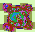

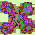

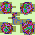

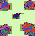

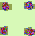

In [13]:
sprites = parseShallowCompressedSpriteArray(zinit.getRecord(1, kind="video"), makeRandomClut())
for s in sprites:
    display(s)

In [14]:
sprites = parseShallowCompressedSpriteArray(zinit.getRecord(2, kind="video"), makeRandomClut())
for s in sprites:
    display(s)

10008
27 27 729
11928
31 32 992
11928
31 32 992
11928
31 32 992
8092
31 22 682
8476
31 23 713


In [15]:
sprites = parseShallowCompressedSpriteArray(zinit.getRecord(3, kind="video"), makeRandomClut())
for s in sprites:
    display(s)

5384
11 15 165
5384
11 15 165
5388
11 15 165
5384
11 15 165
5388
11 15 165
5384
11 15 165
5388
11 15 165
5384
11 15 165
5384
11 15 165
5384
11 15 165


In [17]:
invClut = getClut(mainFile.subFiles["invent"].getRecord(0, kind="data"))
treasureSpriteData = mainFile.subFiles["invent"].getRecord(1, kind="video")
weaponSpriteData = mainFile.subFiles["invent"].getRecord(2, kind="video")

weapons = parseShallowCompressedSpriteArray(weaponSpriteData, invClut)
treasures = parseShallowCompressedSpriteArray(treasureSpriteData, invClut)

print("weapons:")
for i, sprite in enumerate(weapons):
    display(sprite)
    print("i=", i, "combined=", i + 1)
print("treasures")
for i, sprite in enumerate(treasures):
    display(sprite)
    print("i=", i, "combined=", i + 1 + len(weapons))

Clut size: 256 colors
11552
31 31 961
11548
31 31 961
11552
31 31 961
11928
27 32 864
9248
31 25 775
10396
27 28 756
11924
27 32 864
10388
23 28 644
11928
31 32 992
11548
31 31 961
11920
31 32 992
11168
31 30 930
8852
31 24 744
11552
31 31 961
11932
31 32 992
11924
31 32 992
9604
31 26 806
11540
31 31 961
10780
27 29 783
11168
31 30 930
10780
31 29 899
11552
31 31 961
11936
31 32 992
11548
27 31 837
11544
27 31 837
9240
31 25 775
10392
27 28 756
11164
27 30 810
11164
31 30 930
11552
31 31 961
7712
31 21 651
11936
31 32 992
11544
27 31 837
9632
31 26 806
9612
31 26 806
11924
31 32 992
11924
31 32 992
11924
31 32 992
11924
31 32 992
11924
31 32 992
11924
31 32 992
11924
31 32 992
8848
23 24 552
11932
27 32 864
11524
31 31 961
11928
27 32 864
11936
31 32 992
11164
31 30 930
10376
31 28 868
10772
31 29 899
8864
31 24 744
11540
27 31 837
11160
31 30 930
11160
31 30 930
11160
31 30 930
11160
31 30 930
11160
31 30 930
11160
31 30 930
11160
31 30 930
11548
31 31 961
10772
31 29 899
11936
31 32

i= 0 combined= 1


i= 1 combined= 2


i= 2 combined= 3


i= 3 combined= 4


i= 4 combined= 5


i= 5 combined= 6


i= 6 combined= 7


i= 7 combined= 8


i= 8 combined= 9


i= 9 combined= 10


i= 10 combined= 11


i= 11 combined= 12


i= 12 combined= 13


i= 13 combined= 14


i= 14 combined= 15


i= 15 combined= 16


i= 16 combined= 17


i= 17 combined= 18


i= 18 combined= 19


i= 19 combined= 20


i= 20 combined= 21


i= 21 combined= 22


i= 22 combined= 23


i= 23 combined= 24
treasures


i= 0 combined= 25


i= 1 combined= 26


i= 2 combined= 27


i= 3 combined= 28


i= 4 combined= 29


i= 5 combined= 30


i= 6 combined= 31


i= 7 combined= 32


i= 8 combined= 33


i= 9 combined= 34


i= 10 combined= 35


i= 11 combined= 36


i= 12 combined= 37


i= 13 combined= 38


i= 14 combined= 39


i= 15 combined= 40


i= 16 combined= 41


i= 17 combined= 42


i= 18 combined= 43


i= 19 combined= 44


i= 20 combined= 45


i= 21 combined= 46


i= 22 combined= 47


i= 23 combined= 48


i= 24 combined= 49


i= 25 combined= 50


i= 26 combined= 51


i= 27 combined= 52


i= 28 combined= 53


i= 29 combined= 54


i= 30 combined= 55


i= 31 combined= 56


i= 32 combined= 57


i= 33 combined= 58


i= 34 combined= 59


i= 35 combined= 60


i= 36 combined= 61


i= 37 combined= 62


i= 38 combined= 63


i= 39 combined= 64


i= 40 combined= 65


i= 41 combined= 66


i= 42 combined= 67


i= 43 combined= 68


i= 44 combined= 69


i= 45 combined= 70


i= 46 combined= 71


i= 47 combined= 72


i= 48 combined= 73


i= 49 combined= 74


i= 50 combined= 75


i= 51 combined= 76


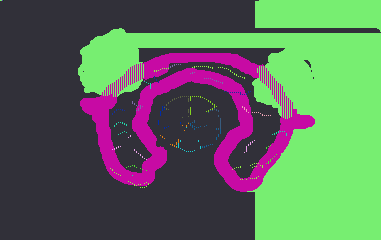

In [19]:
cellUnkImage = overFiles.subFiles["g23"].getRecord(1, kind="video")
display(rl7ToRGB(cellUnkImage, bytes(makeRandomClut())))